In [3]:
import os
import shutil
import hashlib
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm
from mtcnn import MTCNN

2025-12-14 07:07:44.004682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765696064.197539      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765696064.253531      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install -q mtcnn tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 20.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 

In [4]:
SRC_DIR = "/kaggle/input/fer2013plus/fer2013plus/fer2013/train"
BASE_OUT = "/kaggle/working/preprocessed_images"

CLEAN_DIR = os.path.join(BASE_OUT, "train")
REMOVED_DIR = os.path.join(BASE_OUT, "removed_images")

for sub in ["corrupt", "duplicate", "no_face"]:
    os.makedirs(os.path.join(REMOVED_DIR, sub), exist_ok=True)

os.makedirs(CLEAN_DIR, exist_ok=True)

In [5]:
detector = MTCNN()

I0000 00:00:1765696098.130104      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:
def is_valid_image(path):
    try:
        img = Image.open(path)
        img.verify()
        return True
    except:
        return False

In [7]:
def get_image_hash(path):
    img = Image.open(path).convert("L").resize((64, 64))
    return hashlib.md5(np.array(img)).hexdigest()

In [8]:
def has_face(path):
    try:
        img = Image.open(path).convert("RGB")
        faces = detector.detect_faces(np.array(img))
        return len(faces) > 0
    except:
        return False

In [9]:
seen_hashes = set()
log_records = []
stats = {}

for label in sorted(os.listdir(SRC_DIR)):
    src_label = os.path.join(SRC_DIR, label)
    dst_label = os.path.join(CLEAN_DIR, label)

    if not os.path.isdir(src_label):
        continue

    os.makedirs(dst_label, exist_ok=True)

    stats[label] = {
        "total": 0,
        "kept": 0,
        "corrupt": 0,
        "duplicate": 0,
        "no_face": 0
    }

    for fname in tqdm(os.listdir(src_label), desc=f"Processing {label}"):
        src_img = os.path.join(src_label, fname)
        stats[label]["total"] += 1

        reason = "kept"

        # 1️⃣ Corrupt image
        if not is_valid_image(src_img):
            reason = "corrupt"
            stats[label]["corrupt"] += 1
            shutil.copy(src_img, os.path.join(REMOVED_DIR, "corrupt", fname))
        
        else:
            # 2️⃣ Duplicate image
            try:
                img_hash = get_image_hash(src_img)
            except:
                reason = "corrupt"
                stats[label]["corrupt"] += 1
                shutil.copy(src_img, os.path.join(REMOVED_DIR, "corrupt", fname))
                log_records.append({
                    "image": fname,
                    "label": label,
                    "status": reason
                })
                continue

            if img_hash in seen_hashes:
                reason = "duplicate"
                stats[label]["duplicate"] += 1
                shutil.copy(src_img, os.path.join(REMOVED_DIR, "duplicate", fname))
            else:
                seen_hashes.add(img_hash)

                # 3️⃣ Face detection
                if not has_face(src_img):
                    reason = "no_face"
                    stats[label]["no_face"] += 1
                    shutil.copy(src_img, os.path.join(REMOVED_DIR, "no_face", fname))
                else:
                    shutil.copy(src_img, os.path.join(dst_label, fname))
                    stats[label]["kept"] += 1

        log_records.append({
            "image": fname,
            "label": label,
            "status": reason
        })

Processing surprise: 100%|██████████| 3562/3562 [04:18<00:00, 13.80it/s]


In [10]:
log_df = pd.DataFrame(log_records)
log_path = os.path.join(BASE_OUT, "preprocessing_log.csv")
log_df.to_csv(log_path, index=False)

print("✅ Log saved at:", log_path)

✅ Log saved at: /kaggle/working/preprocessed_images/preprocessing_log.csv


In [11]:
summary_df = pd.DataFrame(stats).T
summary_df["removed_total"] = (
    summary_df["corrupt"] +
    summary_df["duplicate"] +
    summary_df["no_face"]
)

summary_df

,total,kept,corrupt,duplicate,no_face,removed_total
anger,2466,1836,0,120,510,630
contempt,165,141,0,7,17,24
disgust,191,139,0,22,30,52
fear,652,484,0,52,116,168
happiness,7528,6405,0,165,958,1123
neutral,10308,8638,0,226,1444,1670
sadness,3514,2432,0,131,951,1082
surprise,3562,2578,0,492,492,984


In [12]:
print("\n📊 OVERALL SUMMARY")
print(summary_df.sum())


📊 OVERALL SUMMARY
total            28386
kept             22653
corrupt              0
duplicate         1215
no_face           4518
removed_total     5733
dtype: int64


In [13]:
summary_path = os.path.join(BASE_OUT, "preprocessing_summary.csv")
summary_df.to_csv(summary_path)
print("✅ Summary saved at:", summary_path)

✅ Summary saved at: /kaggle/working/preprocessed_images/preprocessing_summary.csv


In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda import amp

from torchvision import datasets, transforms
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report

In [37]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cuda


In [16]:
TRAIN_DIR = "/kaggle/working/preprocessed_images/train"
TEST_DIR  = "/kaggle/input/fer2013plus/fer2013plus/fer2013/test"

In [17]:
class_counts = {}
total_images = 0

for cls in sorted(os.listdir(TRAIN_DIR)):
    cls_path = os.path.join(TRAIN_DIR, cls)
    if os.path.isdir(cls_path):
        count = len(os.listdir(cls_path))
        class_counts[cls] = count
        total_images += count

df_counts = pd.DataFrame.from_dict(
    class_counts, orient="index", columns=["Images"]
)

df_counts

,Images
anger,1836
contempt,141
disgust,139
fear,484
happiness,6405
neutral,8638
sadness,2432
surprise,2578


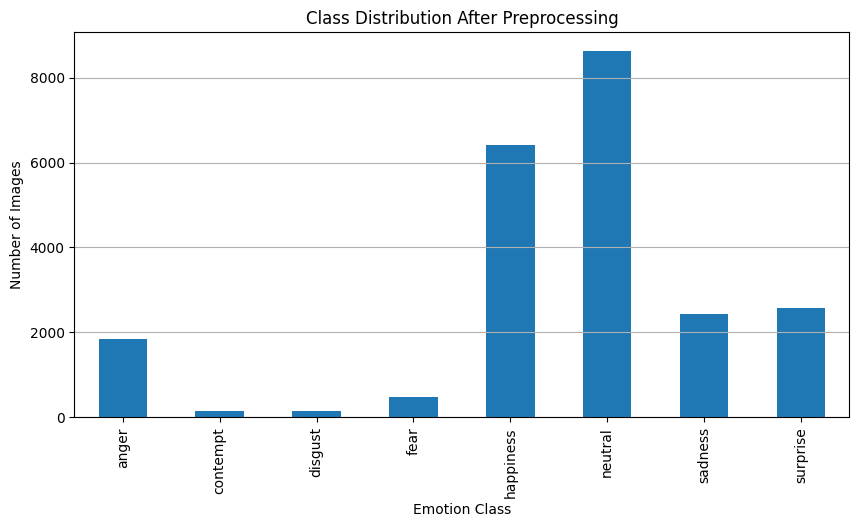

In [18]:
plt.figure(figsize=(10,5))
df_counts["Images"].plot(kind="bar")
plt.title("Class Distribution After Preprocessing")
plt.xlabel("Emotion Class")
plt.ylabel("Number of Images")
plt.grid(axis="y")
plt.show()

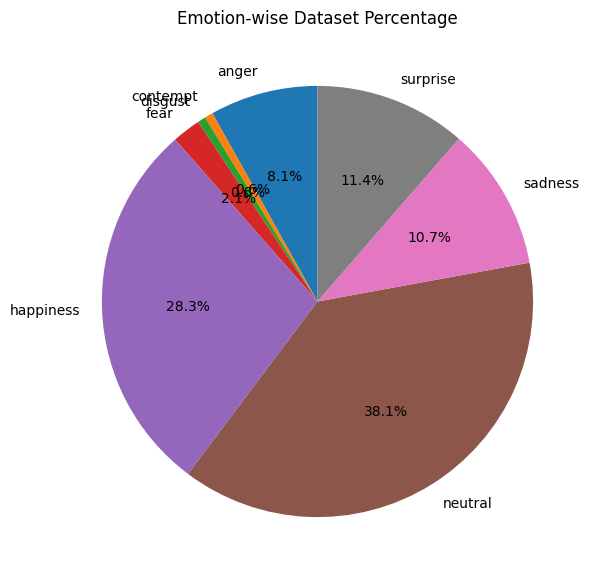

In [19]:
plt.figure(figsize=(7,7))
plt.pie(
    df_counts["Images"],
    labels=df_counts.index,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Emotion-wise Dataset Percentage")
plt.show()

In [28]:
IMG_SIZE = 260
BATCH_SIZE = 24
NUM_WORKERS = 2

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

In [29]:
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
test_dataset  = datasets.ImageFolder(TEST_DIR, transform=test_tf)

print("Train classes:", train_dataset.classes)
print("Test classes :", test_dataset.classes)

assert train_dataset.classes == test_dataset.classes, "❌ CLASS ORDER MISMATCH"

CLASS_NAMES = train_dataset.classes
NUM_CLASSES = len(CLASS_NAMES)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

Train classes: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
Test classes : ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


In [30]:
counts = np.bincount(train_dataset.targets)
class_weights = torch.tensor(1.0 / counts, dtype=torch.float).to(DEVICE)

print("Class weights:", class_weights)

Class weights: tensor([0.0005, 0.0071, 0.0072, 0.0021, 0.0002, 0.0001, 0.0004, 0.0004],
       device='cuda:0')


In [31]:
weights = EfficientNet_B2_Weights.IMAGENET1K_V1
model = efficientnet_b2(weights=weights)

# Freeze everything first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last 5 blocks (CRITICAL FIX)
for param in model.features[-5:].parameters():
    param.requires_grad = True

# Replace classifier
model.classifier[1] = nn.Linear(
    model.classifier[1].in_features,
    NUM_CLASSES
)

model = model.to(DEVICE)

In [32]:
criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=0.0
)

In [33]:
optimizer = optim.AdamW([
    {"params": model.features[-5:].parameters(), "lr": 3e-5},
    {"params": model.classifier.parameters(), "lr": 5e-4}
], weight_decay=1e-4)

scaler = amp.GradScaler()

/tmp/ipykernel_47/3222069150.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


In [38]:
def train_one_epoch(model, loader):
    model.train()
    loss_sum, correct, total = 0, 0, 0

    for x, y in tqdm(loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()

        # ✅ Correct AMP usage for Kaggle
        with amp.autocast():
            out = model(x)
            loss = criterion(out, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_sum += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    return loss_sum / total, correct / total

In [39]:
EPOCHS = 10
history = {"train_acc": [], "test_acc": []}

for epoch in range(EPOCHS):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    te_loss, te_acc = evaluate(model, test_loader)

    history["train_acc"].append(tr_acc)
    history["test_acc"].append(te_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc={tr_acc:.4f} | Test Acc={te_acc:.4f}")

  0%|          | 0/944 [00:00<?, ?it/s]/tmp/ipykernel_47/1918706874.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 944/944 [01:46<00:00,  8.89it/s]


Epoch 1/10 | Train Acc=0.4871 | Test Acc=0.5884


100%|██████████| 944/944 [01:45<00:00,  8.94it/s]


Epoch 2/10 | Train Acc=0.6366 | Test Acc=0.6646


100%|██████████| 944/944 [01:46<00:00,  8.88it/s]


Epoch 3/10 | Train Acc=0.6930 | Test Acc=0.6694


100%|██████████| 944/944 [01:45<00:00,  8.91it/s]


Epoch 4/10 | Train Acc=0.7317 | Test Acc=0.7000


100%|██████████| 944/944 [01:46<00:00,  8.90it/s]


Epoch 5/10 | Train Acc=0.7588 | Test Acc=0.7142


100%|██████████| 944/944 [01:46<00:00,  8.88it/s]


Epoch 6/10 | Train Acc=0.7873 | Test Acc=0.7245


100%|██████████| 944/944 [01:46<00:00,  8.90it/s]


Epoch 7/10 | Train Acc=0.8040 | Test Acc=0.7266


100%|██████████| 944/944 [01:46<00:00,  8.90it/s]


Epoch 8/10 | Train Acc=0.8222 | Test Acc=0.7311


100%|██████████| 944/944 [01:46<00:00,  8.88it/s]


Epoch 9/10 | Train Acc=0.8337 | Test Acc=0.7577


100%|██████████| 944/944 [01:46<00:00,  8.90it/s]


Epoch 10/10 | Train Acc=0.8492 | Test Acc=0.7688


In [40]:
# 🔓 Unfreeze last 5 EfficientNet blocks for fine-tuning
for param in model.features[-5:].parameters():
    param.requires_grad = True

In [41]:
optimizer = optim.AdamW(
    [
        {"params": model.features[-5:].parameters(), "lr": 3e-5},  # backbone
        {"params": model.classifier.parameters(), "lr": 5e-4}      # classifier
    ],
    weight_decay=1e-4
)

In [42]:
EPOCHS_FINE_TUNE = 8

for epoch in range(EPOCHS_FINE_TUNE):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    te_loss, te_acc = evaluate(model, test_loader)

    history["train_acc"].append(tr_acc)
    history["test_acc"].append(te_acc)

    print(
        f"[Fine-Tune] Epoch {epoch+1}/{EPOCHS_FINE_TUNE} | "
        f"Train Acc={tr_acc:.4f} | Test Acc={te_acc:.4f}"
    )

  0%|          | 0/944 [00:00<?, ?it/s]/tmp/ipykernel_47/1918706874.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
100%|██████████| 944/944 [01:46<00:00,  8.90it/s]


[Fine-Tune] Epoch 1/8 | Train Acc=0.8635 | Test Acc=0.7626


100%|██████████| 944/944 [01:46<00:00,  8.90it/s]


[Fine-Tune] Epoch 2/8 | Train Acc=0.8760 | Test Acc=0.7622


100%|██████████| 944/944 [01:45<00:00,  8.92it/s]


[Fine-Tune] Epoch 3/8 | Train Acc=0.8816 | Test Acc=0.7763


100%|██████████| 944/944 [01:45<00:00,  8.91it/s]


[Fine-Tune] Epoch 4/8 | Train Acc=0.8947 | Test Acc=0.7822


100%|██████████| 944/944 [01:45<00:00,  8.91it/s]


[Fine-Tune] Epoch 5/8 | Train Acc=0.9024 | Test Acc=0.7853


100%|██████████| 944/944 [01:46<00:00,  8.90it/s]


[Fine-Tune] Epoch 6/8 | Train Acc=0.9107 | Test Acc=0.7857


100%|██████████| 944/944 [01:45<00:00,  8.91it/s]


[Fine-Tune] Epoch 7/8 | Train Acc=0.9188 | Test Acc=0.7783


100%|██████████| 944/944 [01:46<00:00,  8.90it/s]


[Fine-Tune] Epoch 8/8 | Train Acc=0.9257 | Test Acc=0.7943


In [43]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

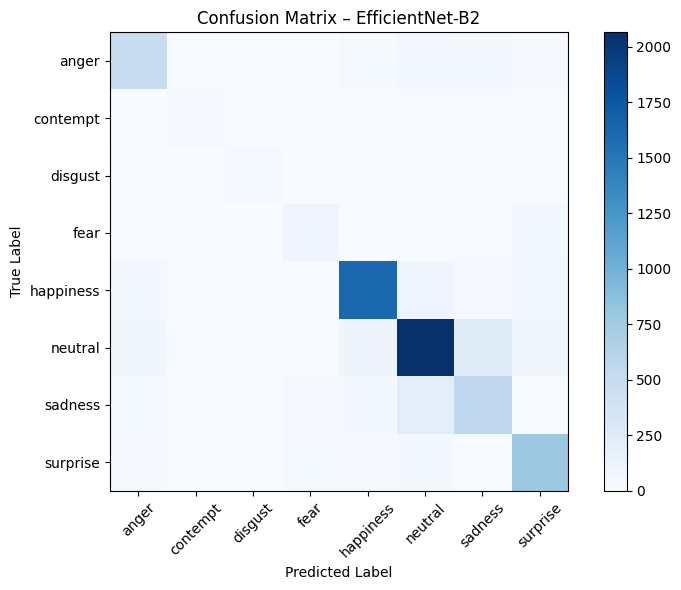

In [44]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.colorbar()

plt.xticks(range(NUM_CLASSES), CLASS_NAMES, rotation=45)
plt.yticks(range(NUM_CLASSES), CLASS_NAMES)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – EfficientNet-B2")

plt.tight_layout()
plt.show()

In [45]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=CLASS_NAMES,
        digits=4
    )
)

              precision    recall  f1-score   support

       anger     0.7176    0.7655    0.7408       644
    contempt     0.3864    0.3333    0.3579        51
     disgust     0.5192    0.4737    0.4954        57
        fear     0.5663    0.5629    0.5646       167
   happiness     0.8965    0.8818    0.8891      1827
     neutral     0.8320    0.7951    0.8132      2597
     sadness     0.6138    0.6460    0.6295       856
    surprise     0.8031    0.8656    0.8332       900

    accuracy                         0.7943      7099
   macro avg     0.6669    0.6655    0.6654      7099
weighted avg     0.7963    0.7943    0.7948      7099



In [46]:
MODEL_PATH = "best_emotion_model_efficientnet_b2.pth"

torch.save({
    "model_name": "efficientnet_b2",
    "num_classes": NUM_CLASSES,
    "class_names": CLASS_NAMES,
    "img_size": IMG_SIZE,
    "model_state_dict": model.state_dict()
}, MODEL_PATH)

print("✅ Model saved successfully:", MODEL_PATH)

✅ Model saved successfully: best_emotion_model_efficientnet_b2.pth


In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train")
plt.plot(history["test_loss"], label="Test")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train")
plt.plot(history["test_acc"], label="Test")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

In [ ]:
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        out = model(x.to(DEVICE))
        y_pred.extend(out.argmax(1).cpu().numpy())
        y_true.extend(y.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks(range(NUM_CLASSES), CLASS_NAMES, rotation=45)
plt.yticks(range(NUM_CLASSES), CLASS_NAMES)
plt.title("Confusion Matrix – EfficientNet-B2")
plt.show()

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "class_names": CLASS_NAMES,
    "img_size": IMG_SIZE
}, "best_emotion_model_efficientnet_b2.pth")

print("✅ Final EfficientNet-B2 model saved")

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda import amp

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

from pathlib import Path
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

In [ ]:
DATA_DIR = Path("/kaggle/input/fer2013plus/fer2013plus/fer2013")
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR  = DATA_DIR / "test"

print(TRAIN_DIR.exists(), TEST_DIR.exists())

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS_STAGE1 = 6     # feature extraction
EPOCHS_STAGE2 = 6     # fine-tuning
NUM_WORKERS = 0       # safest for Kaggle

In [ ]:
def apply_clahe(pil_img):
    """
    Input: PIL Image
    Output: PIL Image (RGB)
    """
    gray = pil_img.convert("L")
    gray_np = np.array(gray)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray_np)

    return Image.fromarray(enhanced).convert("RGB")

In [ ]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

In [ ]:
from torch.utils.data import Dataset
from torchvision.datasets.folder import default_loader

class FERDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = []

        for label_idx, label_name in enumerate(sorted(os.listdir(root))):
            label_path = os.path.join(root, label_name)
            if not os.path.isdir(label_path):
                continue
            for fname in os.listdir(label_path):
                if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.samples.append(
                        (os.path.join(label_path, fname), label_idx)
                    )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, label = self.samples[index]

        # ✅ Always load as PIL Image
        img = default_loader(path)   # PIL Image

        # ✅ CLAHE on PIL
        img = apply_clahe(img)

        # ✅ Torchvision transforms AFTER preprocessing
        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
train_dataset = FERDataset(TRAIN_DIR, transform=train_tf)
test_dataset  = FERDataset(TEST_DIR, transform=test_tf)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

In [ ]:
weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
model = convnext_tiny(weights=weights)

# Stage-1: Freeze backbone
for param in model.features.parameters():
    param.requires_grad = False

model.classifier[2] = nn.Linear(
    model.classifier[2].in_features,
    NUM_CLASSES
)

model = model.to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.AdamW(
    model.classifier.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

scaler = amp.GradScaler()

In [ ]:
history = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

In [ ]:
def train_one_epoch(model, loader):
    model.train()
    loss_sum, correct, total = 0, 0, 0

    for x, y in tqdm(loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()

        with amp.autocast():
            out = model(x)
            loss = criterion(out, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_sum += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    return loss_sum / total, correct / total


def evaluate(model, loader):
    model.eval()
    loss_sum, correct, total = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)

            loss_sum += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    return loss_sum / total, correct / total

In [ ]:
for epoch in range(EPOCHS_STAGE1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    te_loss, te_acc = evaluate(model, test_loader)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["test_loss"].append(te_loss)
    history["test_acc"].append(te_acc)

    print(f"[Stage-1] Epoch {epoch+1} | Train Acc={tr_acc:.4f} | Test Acc={te_acc:.4f}")

In [ ]:
for param in model.features[-2:].parameters():
    param.requires_grad = True

optimizer = optim.AdamW([
    {"params": model.features[-2:].parameters(), "lr": 1e-5},
    {"params": model.classifier.parameters(), "lr": 1e-4}
])

In [ ]:
for epoch in range(EPOCHS_STAGE2):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    te_loss, te_acc = evaluate(model, test_loader)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["test_loss"].append(te_loss)
    history["test_acc"].append(te_acc)

    print(f"[Fine-Tune] Epoch {epoch+1} | Train Acc={tr_acc:.4f} | Test Acc={te_acc:.4f}")

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["test_loss"], label="Test Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["test_acc"], label="Test Acc")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

In [ ]:
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        out = model(x.to(DEVICE))
        y_pred.extend(out.argmax(1).cpu().numpy())
        y_true.extend(y.numpy())

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "class_names": CLASS_NAMES,
    "img_size": IMG_SIZE
}, "best_emotion_model_convnext.pth")

print("✅ Model saved successfully")